## Работу выполнили: 
Гаврилова Анастасия (БЭК201), Кондратьева Надежда (БЭК201), Никитюк Михаил (БЭК203)

## В качестве сайта для парсинга мы выбрали airbnb. 

### Библиотеки

In [3]:
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as bs
import pandas as pd
from collections import defaultdict
import time
import csv
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import warnings
warnings.filterwarnings("ignore")

### Шаг 1. Парсинг датасета

In [ ]:
# Пишем функцию, которая будет собирать данные со страницы одной квартиры:
def flat_working(new_tree):
    data = [0]*28 #Создаем список, который будет содержать всю информацию об одной квартире
    
    # name - парсим название квартиры
    try:
        name = new_tree.find('span', {"class": "_9cqu50"}).h1.text
    except:
        name = 'NaN'
    data[0] = name
    
    #price - парсим цену 
    try:
        price = new_tree.find('span', {"class": "_me8w3a0"}).text
        price = price.replace('\xa0', '')
        price = int(price[:-1])
    except:
        price = 'NaN'
    data[1] = price
    
    #rate - парсим рейтинг квартиры
    try:
        rate = float(new_tree.find('span', {"class": "_12si43g"}).text)
    except:
        rate = 0
    data[2] = rate
    
    #reviews - парсим количество отзывов
    try:
        reviews = new_tree.find('span', {"class": "_1qx9l5ba"}).text
        reviews = int(reviews.split()[0][1:])
    except:
        reviews = 0
    data[3] = reviews
    
    #superman - смотрим на наличие статуса "Суперхозяин"
    try:
        superman = new_tree.find('span', {"class": "_1v6fb3wh"}).text
        if 'Суперхозяин' in superman:
            superman = 1
        else:
            superman = 0
    except:
        superman = 0
    data[4] = superman
        
    #status - смотрим, сдается ли квартира целиком
    try:
        status = new_tree.find('div', {"class": "_1qsawv5"}).text
        if 'целиком' in status:
            status = 1
        else:
            status = 0
    except:
        status = 'NaN'
    data[5] = status
        
    #guests - смотрим на максимальную вместимость квартиры (сколько гостей максимально может быть)
    grbb = [0, 0, 0, 0]
    try:
        gts = new_tree.find('div', {"class": "_tqmy57"})
        for i in range(0, len(gts.find_all("span")), 2):
            grbb[i//2] = gts.find_all("span")[i].text.split()[0]
        print(grbb)
        data[6] = grbb[0]
        data[7] = grbb[1]
        data[8] = grbb[2]
        data[9] = grbb[3]
    except:
        print('Не прошло')

    
    #features - собираем информацию о наличии(отсутствии) основных удобств в квартире (список удобств в массиве ниже)
    features = ['Кухня', 'Кондиционер', 'Стиральная машина', 'Посудомоечная машина', 'Духовка', 
              'Плита', 'Холодильник', 'Самостоятельное прибытие']
    try:
        infa = new_tree.find("div", {'class': "b6xigss dir dir-ltr"})
        l = 'https://www.airbnb.ru' + infa.a.get('href')
        driver = webdriver.Chrome('D:\Загрузки\chromedriver_win32\chromedriver.exe')
        driver.get(l)
        time.sleep(10)
        respon = driver.page_source
        driver.close()
        p = bs(respon)
        slovar = {}
        for feat in (p.find_all('div', {'class': '_aujnou'})[1:-1]):
            z = feat.find_all('div', {'class': '_vzrbjl'})
            for f in z:
                a = str(f)
                if '<div class="_1fuoz48">' in a:
                    slovar[a.split('<div class="_1fuoz48">')[0].split('<div class="_vzrbjl">')[1]] = 1
                else:
                    slovar[f.text] = 1
        for feats in range(len(features)):
                if features[feats] in slovar:
                    features[feats] = 1
                else:
                    features[feats] = 0
    except:
        features = ['Error', 'Error', 'Error', 'Error', 'Error', 'Error', 'Error', 'Error']
    
    data[10] = features[0]
    data[11] = features[1]
    data[12] = features[2]
    data[13] = features[3]
    data[14] = features[4]
    data[15] = features[5]
    data[16] = features[6]
    data[17] = features[7]
    
    #airprice and cleanprice - смотрим на величину сбора за услуги airbnb и платы за уборку
    try:
        service_name = new_tree.find_all("div", {'class': "_m6lwl6"})
        service_price = new_tree.find_all("span", {'class': "_1k4xcdh"})
        if service_name[1].text == 'Плата за уборку':
            cleanprice = service_price[1].text[:-1]
            cleanprice = int(cleanprice.replace('\xa0', ''))
        else:
            cleanprice = 0

        if service_name[1].text == 'Сбор за услуги Airbnb':
            airprice = service_price[1].text[:-1]
            airprice = int(airprice.replace('\xa0', ''))
        elif service_name[2].text == 'Сбор за услуги Airbnb':
            airprice = service_price[2].text[:-1]
            airprice = int(airprice.replace('\xa0', ''))
        else:
            airprice = 0
    except:
        cleanprice = 0
        airprice = 0

    data[18] = cleanprice
    data[19] = airprice
    
    #ka4estva - смотрим на оценку показателей: чистоты, общения, прибытия, точности, местоположения и соотношения цены/качества
    ka4estva = [0, 0, 0, 0, 0, 0]
    try:
        podrobnee = new_tree.find_all('div', {'class': '_1s11ltsf'})
        for item in range(len(podrobnee)):
            w = float(podrobnee[item].find('span', {'class': '_4oybiu'}).text)
            ka4estva[item] = w
    except:
        pass
    data[20] = ka4estva[0]
    data[21] = ka4estva[1]
    data[22] = ka4estva[2]
    data[23] = ka4estva[3]
    data[24] = ka4estva[4]
    data[25] = ka4estva[5]
    
    #animals, smoking - смотрим, возможно ли пребываение с животными и можно ли курить в квартире
    try:
        categories = new_tree.find('div', {"class": '_m9x7bnz'})
        sp = categories.find_all('div', {"class": '_u827kd'})
        animals = 0
        smoking = 0
        for item in sp:
            if ('Можно с животными' in item.find('span').text) or ('Можно с питомцами' in item.find('span').text):
                animals += 1
            if 'Можно курить' in item.find('span').text:
                smoking += 1
        if animals > 0:
            animals = 1
        if smoking > 0:
            smoking = 1
    except:
        animals = 0
        smoking = 0

    data[26] = animals
    data[27] = smoking
    
    return data
    
# массивы, значения которых будем подстав
mon = ['june', 'july', 'august'] # список месяцев, было проверено, что именно так они выглядят в ссылках
count = [1, 2, 3] # количество гостей
length = ['one_week', 'weekend_trip', 'one_month'] # продолжительность поездки
index = 0 # индекс в будущем словаре из которого будет создана таблица
d = {} # словарь из которого в дальнейшем будет создан dataframe
for month in tqdm(range(len(mon))):
    for p in tqdm(range(len(count))):
        for l in tqdm(range(len(length))):
            for q in tqdm(range(3)):
                link = f"https://www.airbnb.ru/s/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0--%D0%B3%D0%BE%D1%80%D0%BE%D0%B4-%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D={mon[month]}&date_picker_type=flexible_dates&adults={count[p]}&source=structured_search_input_header&search_type=filter_change&place_id=ChIJybDUc_xKtUYRTM9XV8zWRD0&flexible_trip_lengths%5B%5D={length[l]}&place_id=ChIJybDUc_xKtUYRTM9XV8zWRD0&federated_search_session_id=32499ca4-060b-490a-9978-2b2465e4ba95&pagination_search=true&items_offset={20*q}&section_offset=3"
                    # цикл создает необходимую ссылку по которой будет происходить общий парсинг
                driver = webdriver.Chrome('D:\Загрузки\chromedriver_win32\chromedriver.exe')
                    # открывается сторонний селениум драйвер для парсинга голового кода страницы
                driver.get(link)
                time.sleep(10)
                response = driver.page_source
                driver.close()
                    # получени кода страницы завершено
                tr = bs(response)
                    # создаем красивый суп
                flat = tr.find_all("div", {"class": "_8ssblpx"})
                    # пробегаемся по коду в поисках отдельных квартир
                name = [item.div.meta.get('content') for item in flat]
                    # забираем названия данных квартир
                hrefs = ['https://www.airbnb.ru' + item.a.get('href') for item in flat]
                    # забираем ссылки на каждую квартиру, представленную на сайте (всего в среднем было 20 ссылок, иногда больше)
                for item in tqdm(range(15)): # начинаем проходить каждую страницу (было решено ограничиться 15 квартирами на странице, всего страниц 3)
                    dr = webdriver.Chrome('D:\Загрузки\chromedriver_win32\chromedriver.exe')
                    dr.get(hrefs[item])
                        # забираем код конкретной квартиры
                    time.sleep(10)
                    page = dr.page_source
                    dr.close()
                    new_tree = bs(page)
                    data = flat_working(new_tree) # вызываем функцию, которая по странице квартиры будет собирать из нее ключевую информацию
                    d[index] = [hrefs[item], data[0], mon[month], count[p], length[l], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], 
                                data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], 
                                data[18], data[19], data[20], data[21], data[22], data[23], data[24], data[25], data[26], data[27]]
                        # в словарь d под определенным индексом вносятся все собранные параметры
                    index += 1 # изменяем индекс для дальнейшего внесения новых строчек
df = pd.DataFrame(d).T # создаем датасет из собранных данных
df.to_csv(r'C:\Users\manik\OneDrive\Рабочий стол\DZ4_main.csv', index = True) # сохраняем на компьютер

### Шаг 2. Предварительная обработка.

In [21]:
# меняем масштаб будущей таблицы, чтобы были видны все колонки и строчки
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [78]:
# загружаем сохраненный файл
with open('DZ4_main.csv') as f:
    f=list(csv.reader(f, delimiter=","))
df=pd.DataFrame(f)
del df[0] # удаляем ненужный столбец с индексами
df = df.drop(index=[0]) # удаляем ненужную строчку с индексами
df = df.rename(columns={1: "Ссылка",
                        2: 'Название',
                        3: 'Месяц',
                        4: 'Количество гостей',
                        5: 'Время пребывания',
                        6: 'Цена',
                        7: 'Рейтинг',
                        8: 'Количество отзывов',
                        9: 'Суперхозяин',
                        10: 'Статус жилья',
                        11: 'Максимальная вместимость',
                        12: 'Количество комнат',
                        13: 'Количество комнат с кроватями',
                        14: 'Количество ванных',
                        15: 'Кухня',
                        16: 'Кондиционер',
                        17: 'Стиральная машина',
                        18: 'Посудомоечная машина',
                        19: 'Духовка',
                        20: 'Плита',
                        21: 'Холодильник',
                        22: 'Самостоятельное прибытие',
                        23: 'Плата за уборку',
                        24: 'Плата за услуги airbnb',
                        25:'Оценка чистоты',
                        26: 'Оценка точности',
                        27: 'Оценка общения',
                        28: 'Оценка местоположения',
                        29: 'Оценка прибытия',
                        30:'Соотношение цена/качество',
                        31: 'Можно с питомцами',
                        32: 'Курение разрешено'})
df = df.reset_index()
del df['index']
# Формирование читаемой таблицы завершено
df

Ссылка  \
0          https://www.airbnb.ru/rooms/48866485?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
1          https://www.airbnb.ru/rooms/49299498?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
2          https://www.airbnb.ru/rooms/24928627?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
3          https://www.airbnb.ru/rooms/21930312?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
4          https://www.airbnb.ru/rooms/49538258?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
5          https://www.airbnb.ru/rooms/42968796?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
6          https://www.airbnb.ru/rooms/43302272?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
7          https://www.airbnb.ru/rooms/37679001?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
8          https://www.airbnb.ru/rooms/18667896?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
9          https://www.airbnb.ru/rooms/45587695?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
10         https://www.airbnb.ru/rooms/42940132?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
11         https://www.airbnb.ru/rooms/48365164?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
12         https://www.airbnb.ru/rooms/40148577?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
13          https://www.airbnb.ru/rooms/8738855?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
14         https://www.airbnb.ru/rooms/21977235?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
15         https://www.airbnb.ru/rooms/44333546?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
16         https://www.airbnb.ru/rooms/48364557?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
17         https://www.airbnb.ru/rooms/48866390?adults=1&childr

In [79]:
# Изменяем типы объектов колонок тадлицы для того, чтобы с ними было удобнее работать 

# Обрабатываем пропуски:
# Если на сайте указано, что владелец - суперхозяин, в таблице стоит 1, если нет - 0. Заполним пропуски нулями, ведь если на сайте нет информации, значит, человек не суперхозяин.
df['Суперхозяин']=df['Суперхозяин'].replace('NaN',0) 
# Аналогично поступим со статусом жилья: если нет информации о том, сдается оно целиком или нет, примем значение равным нулю для простоты обработки данных
df['Статус жилья']=df['Статус жилья'].replace('NaN',0)
# На каких-то страницах не получилось достать информацию о некоторых удобствах, но это важная часть исследования, поэтому такие страницы мы не будем брать в расчет
df = df[ df['Кухня'] != 'Error' ]

# Заменим некоторые значения в таблице, чтобы можно было сменить тип данных
df['Количество ванных']=df['Количество ванных'].replace('1,5','1.5')
df['Количество ванных']=df['Количество ванных'].replace('Общий','0.5')
df['Количество ванных']=df['Количество ванных'].replace('2,5','2.5')
df['Количество комнат']=df['Количество комнат'].replace('1,5','1.5')
df['Количество комнат']=df['Количество комнат'].replace('студия','0.5')
df['Количество комнат с кроватями']=df['Количество комнат с кроватями'].replace('1,5','1.5')

df['Цена'] = df['Цена'].astype(int)
df['Рейтинг'] = df['Рейтинг'].astype(float)
df['Количество отзывов'] = df['Количество отзывов'].astype(int)
df['Суперхозяин'] = df['Суперхозяин'].astype(int)
df['Статус жилья'] = df['Статус жилья'].astype(int)
df['Максимальная вместимость'] = df['Максимальная вместимость'].astype(int)
df['Количество комнат'] = df['Количество комнат'].astype(float)
df['Количество комнат с кроватями'] = df['Количество комнат с кроватями'].astype(float)
df['Количество ванных'] = df['Количество ванных'].astype(float)
df['Кухня'] = df['Кухня'].astype(int)
df['Кондиционер'] = df['Кондиционер'].astype(int)
df['Стиральная машина'] = df['Стиральная машина'].astype(int)
df['Посудомоечная машина'] = df['Посудомоечная машина'].astype(int)
df['Духовка'] = df['Духовка'].astype(int)
df['Плита'] = df['Плита'].astype(int)
df['Холодильник'] = df['Холодильник'].astype(int)
df['Самостоятельное прибытие'] = df['Самостоятельное прибытие'].astype(int)
df['Плата за уборку'] = df['Плата за уборку'].astype(int)
df['Плата за услуги airbnb'] = df['Плата за услуги airbnb'].astype(int)
df['Оценка чистоты'] = df['Оценка чистоты'].astype(float)
df['Оценка точности'] = df['Оценка точности'].astype(float)
df['Оценка общения'] = df['Оценка общения'].astype(float)
df['Оценка местоположения'] = df['Оценка местоположения'].astype(float)
df['Оценка прибытия'] = df['Оценка прибытия'].astype(float)
df['Соотношение цена/качество'] = df['Соотношение цена/качество'].astype(float)
df['Можно с питомцами'] = df['Можно с питомцами'].astype(int)
df['Курение разрешено'] = df['Курение разрешено'].astype(int)
# Итого получим следующие типы данных в таблице:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211 entries, 0 to 1214
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ссылка                         1211 non-null   object 
 1   Название                       1211 non-null   object 
 2   Месяц                          1211 non-null   object 
 3   Количество гостей              1211 non-null   object 
 4   Время пребывания               1211 non-null   object 
 5   Цена                           1211 non-null   int64  
 6   Рейтинг                        1211 non-null   float64
 7   Количество отзывов             1211 non-null   int64  
 8   Суперхозяин                    1211 non-null   int64  
 9   Статус жилья                   1211 non-null   int64  
 10  Максимальная вместимость       1211 non-null   int64  
 11  Количество комнат              1211 non-null   float64
 12  Количество комнат с кроватями  1211 non-null   f

In [80]:
# Посмотрим внимательнее на столбец "Курение разрешено" и найдем, в каких квартирах курить можно:
display(df[df['Курение разрешено'] != 0])
# Заметим, что в нашем датасете не существует ни одной квартиры, 
# в которой можно курить, поэтому данный столбец не несет никакой дополнительной информации, следовательно: может быть удален
del df['Курение разрешено']
df.reset_index(inplace = True)
del df['index']

Empty DataFrame
Columns: [Ссылка, Название, Месяц, Количество гостей, Время пребывания, Цена, Рейтинг, Количество отзывов, Суперхозяин, Статус жилья, Максимальная вместимость, Количество комнат, Количество комнат с кроватями, Количество ванных, Кухня, Кондиционер, Стиральная машина, Посудомоечная машина, Духовка, Плита, Холодильник, Самостоятельное прибытие, Плата за уборку, Плата за услуги airbnb, Оценка чистоты, Оценка точности, Оценка общения, Оценка местоположения, Оценка прибытия, Соотношение цена/качество, Можно с питомцами, Курение разрешено]
Index: []

### Шаг 3. Создание новых признаков.

In [83]:
# Создаем новые колонки:
    # 1. Аренда жилья: вычисляется как цена за ночь * количество ночей (в случае с выходными - *2; в случае недели - *7; цена за месяц остается без изменений)
    # 2. Стоимость проживания: полная стоимость проживания в зависимости от времени
    # 3. Количество удобств: общая сумма количества удобств (кухня, Кондиционер, Стиральная машина, Посудомоечная машина, Духовка, Плита, Холодильник, Самостоятельное прибытие)
    # 4. Стоимость спального места: цену разделим на максимальную вместимость квартиры 
    # 5. Степень переоцененности: разбиваем квартиры на группы по одинаковым признакам, которые свойственны только этой группе квартир, 
        # затем находим для каждой группы минимальную цену, относительно которой смотрим, насколько люди переплатят за те же услуги
df['Аренда жилья'] = np.where(df['Время пребывания'] == 'weekend_trip', df['Цена']*2, np.where(df['Время пребывания'] == 'one_week', df['Цена']*7, df['Цена']))
df['Стоимость проживания']=df[['Аренда жилья','Плата за уборку', 'Плата за услуги airbnb']].sum(axis=1)
df['Количество удобств']=df[['Кухня','Кондиционер','Стиральная машина', 'Посудомоечная машина','Духовка', 'Плита','Холодильник','Самостоятельное прибытие']].sum(axis=1)
df['Стоимость спального места'] = round(df['Цена'] / df['Максимальная вместимость'], 2)

for item in range(df.shape[0]):
    df['Номер группы'] = list(df.loc[:, ['Время пребывания', 'Статус жилья', 'Максимальная вместимость', 'Количество комнат', 'Количество комнат с кроватями', 'Количество ванных','Кухня','Кондиционер','Стиральная машина','Посудомоечная машина','Духовка','Плита','Холодильник','Можно с питомцами']].values)
df['Номер группы'] = df['Номер группы'].astype(str)
spis = df['Номер группы'].unique()
spis = spis.reshape(-1).tolist()
for g in range(len(spis)):
    for i in range(df.shape[0]):
        if df['Номер группы'][i] == spis[g]:
            df['Номер группы'][i] = g
sl = {}
for q in range(len(spis)):
    pr_data = df.loc[df['Номер группы'] == q]
    sl[q] = pr_data['Цена'].min()
for e in range(len(spis)):
    for w in range(df.shape[0]):
        if df['Номер группы'][w] == e:
            df['Степень переоцененности'][w] = round(df['Цена'][w] / sl[e], 2)
df

Ссылка  \
0     https://www.airbnb.ru/rooms/48866485?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
1     https://www.airbnb.ru/rooms/49299498?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
2     https://www.airbnb.ru/rooms/24928627?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
3     https://www.airbnb.ru/rooms/21930312?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
4     https://www.airbnb.ru/rooms/49538258?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
5     https://www.airbnb.ru/rooms/42968796?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
6     https://www.airbnb.ru/rooms/43302272?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
7     https://www.airbnb.ru/rooms/37679001?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
8     https://www.airbnb.ru/rooms/18667896?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
9     https://www.airbnb.ru/rooms/45587695?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
10    https://www.airbnb.ru/rooms/42940132?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
11    https://www.airbnb.ru/rooms/48365164?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
12    https://www.airbnb.ru/rooms/40148577?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
13     https://www.airbnb.ru/rooms/8738855?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
14    https://www.airbnb.ru/rooms/21977235?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
15    https://www.airbnb.ru/rooms/44333546?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
16    https://www.airbnb.ru/rooms/48364557?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
17    https://www.airbnb.ru/rooms/48866390?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&tr

In [84]:
# Для удобства сортируем значения колонки "Стоимость проживания" по возрастанию с учетом сортировки месяца, числа гостей и времени пребывания
df['Месяц']=df['Месяц'].replace('june', 1)
df['Месяц']=df['Месяц'].replace('july', 2)
df['Месяц']=df['Месяц'].replace('august', 3)
df['Время пребывания']=df['Время пребывания'].replace('weekend_trip', 2)
df['Время пребывания']=df['Время пребывания'].replace('one_week', 7)
df['Время пребывания']=df['Время пребывания'].replace('one_month', 30)
df = df.sort_values(by = ['Месяц', 'Количество гостей', 'Время пребывания', 'Стоимость проживания'], ascending = [True, True, True, True])
df['Месяц']=df['Месяц'].replace(1, 'Июнь')
df['Месяц']=df['Месяц'].replace(2, 'Июль')
df['Месяц']=df['Месяц'].replace(3, 'Август')
df['Время пребывания']=df['Время пребывания'].replace(2, 'Выходные')
df['Время пребывания']=df['Время пребывания'].replace(7, 'Неделя')
df['Время пребывания']=df['Время пребывания'].replace(30, 'Месяц')
df = df.reset_index()
del df['index']
df

Ссылка  \
0     https://www.airbnb.ru/rooms/39080884?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
1     https://www.airbnb.ru/rooms/50141264?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
2     https://www.airbnb.ru/rooms/48255996?adults=1&children=0&infants=0&check_in=2021-06-11&check_out=2021-06-13&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
3     https://www.airbnb.ru/rooms/44333546?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
4     https://www.airbnb.ru/rooms/44148672?adults=1&children=0&infants=0&check_in=2021-06-11&check_out=2021-06-13&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
5     https://www.airbnb.ru/rooms/49954856?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
6     https://www.airbnb.ru/rooms/21665745?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
7     https://www.airbnb.ru/rooms/49707719?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
8     https://www.airbnb.ru/rooms/28159058?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
9     https://www.airbnb.ru/rooms/25768698?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
10    https://www.airbnb.ru/rooms/49791779?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
11    https://www.airbnb.ru/rooms/48365164?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8df3f4d9-0365-4d3d-9047-4d72397dda2d   
12    https://www.airbnb.ru/rooms/48364557?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
13    https://www.airbnb.ru/rooms/44109290?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
14    https://www.airbnb.ru/rooms/39431934?adults=1&children=0&infants=0&check_in=2021-06-18&check_out=2021-06-20&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
15    https://www.airbnb.ru/rooms/48361847?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=8c480d4d-f06a-4f59-98a2-5f2c9c441e96   
16    https://www.airbnb.ru/rooms/49938377?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&translate_ugc=false&federated_search_id=ac0cbb61-0187-4a3d-a926-5623248b7bef   
17    https://www.airbnb.ru/rooms/48866390?adults=1&children=0&infants=0&check_in=2021-06-25&check_out=2021-06-27&previous_page_section_name=1000&tr

### Шаг 4 - 5. Визуализация и работа с pandas

#### Гипотеза 1. Июль - самый дешевый для путешествия месяц.
Для начала рассмотрим, в каком ценовом диапозоне находится наибольшая часть предлагаемых квартир для каждого месяца и продолжительности поездки. Для этого разделим стоимость на несколько категорий и посчитаем количество объявлений. 

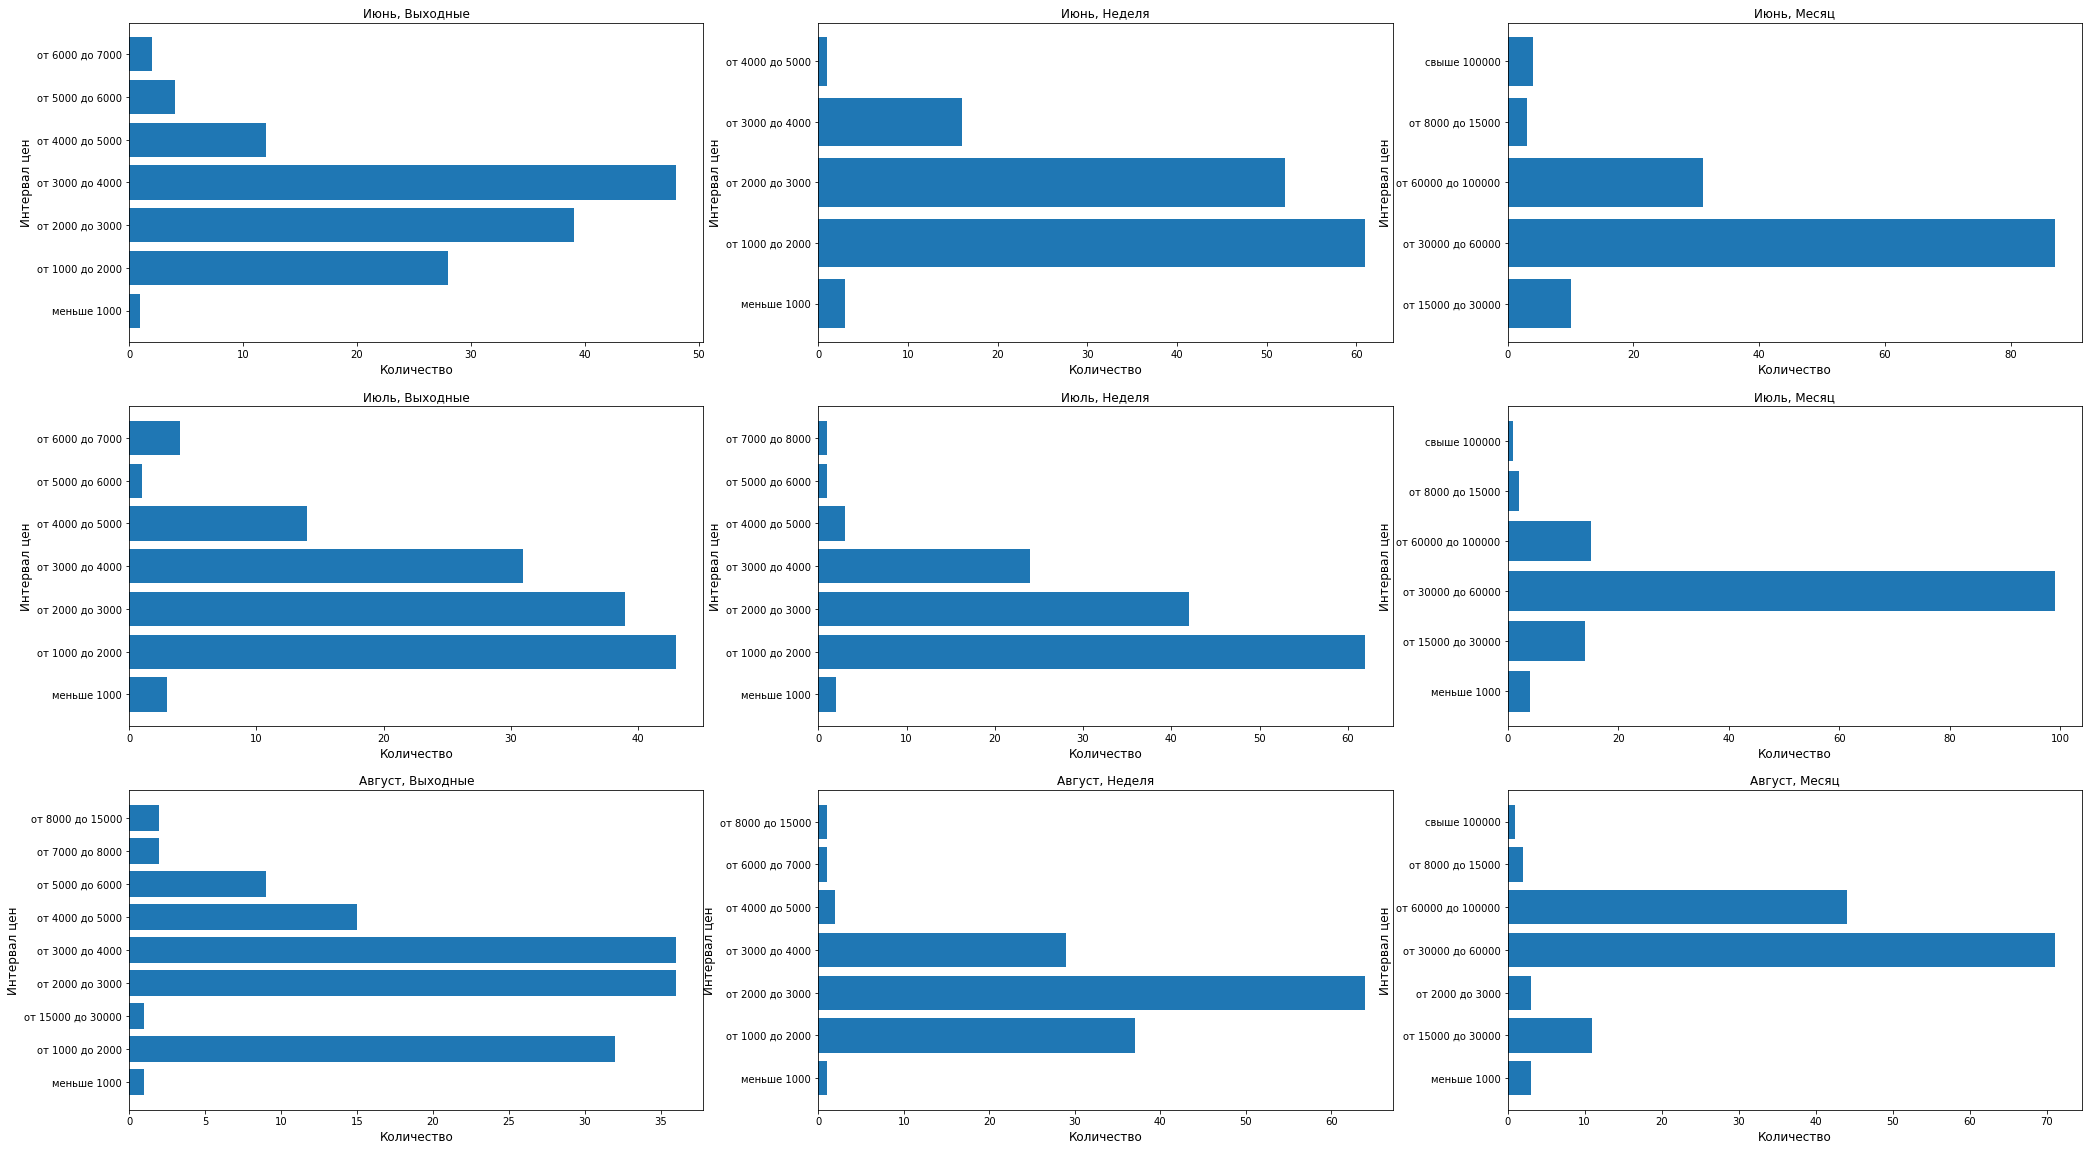

In [85]:
fig, ax= plt.subplots(3, 3, figsize=(35,20))
#Разбиваем на промежутки (продолжительности длиною в месяц цена указана за месяц)
df['Интервал цен'] = np.where(df['Цена'] <1000, 'меньше 1000', np.where( df['Цена']<2000, 'от 1000 до 2000', np.where( df['Цена']<3000, 'от 2000 до 3000', np.where( df['Цена']<4000, 'от 3000 до 4000', np.where(df['Цена']<5000, 'от 4000 до 5000', np.where(df['Цена']<6000, 'от 5000 до 6000', np.where(df['Цена']<7000, 'от 6000 до 7000',np.where(df['Цена']<8000, 'от 7000 до 8000', np.where(df['Цена']<15000, 'от 8000 до 15000', np.where(df['Цена']<30000, 'от 15000 до 30000', np.where(df['Цена']<60000, 'от 30000 до 60000', np.where(df['Цена']<100000, 'от 60000 до 100000', 'свыше 100000'))))))))))))

sim1 = df[df['Месяц'] == 'Июнь']
sim2 = df[df['Месяц'] == 'Июль']
sim3 = df[df['Месяц'] == 'Август']
sim11 = sim1[sim1['Время пребывания'] == 'Выходные'].groupby('Интервал цен').size()
sim12 = sim1[sim1['Время пребывания'] == 'Неделя'].groupby('Интервал цен').size()
sim13 = sim1[sim1['Время пребывания'] == 'Месяц'].groupby('Интервал цен').size()
sim21 = sim2[sim2['Время пребывания'] == 'Выходные'].groupby('Интервал цен').size()
sim22 = sim2[sim2['Время пребывания'] == 'Неделя'].groupby('Интервал цен').size()
sim23 = sim2[sim2['Время пребывания'] == 'Месяц'].groupby('Интервал цен').size()
sim31 = sim3[sim3['Время пребывания'] == 'Выходные'].groupby('Интервал цен').size()
sim32 = sim3[sim3['Время пребывания'] == 'Неделя'].groupby('Интервал цен').size()
sim33 = sim3[sim3['Время пребывания'] == 'Месяц'].groupby('Интервал цен').size()
sim11 = pd.DataFrame(sim11)
sim12 = pd.DataFrame(sim12)
sim13 = pd.DataFrame(sim13)
sim21 = pd.DataFrame(sim21)
sim22 = pd.DataFrame(sim22)
sim23 = pd.DataFrame(sim23)
sim31 = pd.DataFrame(sim31)
sim32 = pd.DataFrame(sim32)
sim33 = pd.DataFrame(sim33)

ax[0][0].barh(sim11.index, sim11[0].values)
ax[0][0].set_title('Июнь, Выходные')
ax[0][1].barh(sim12.index, sim12[0].values)
ax[0][1].set_title('Июнь, Неделя')
ax[0][2].barh(sim13.index, sim13[0].values)
ax[0][2].set_title('Июнь, Месяц')
ax[1][0].barh(sim21.index, sim21[0].values)
ax[1][0].set_title('Июль, Выходные')
ax[1][1].barh(sim22.index, sim22[0].values)
ax[1][1].set_title('Июль, Неделя')
ax[1][2].barh(sim23.index, sim23[0].values)
ax[1][2].set_title('Июль, Месяц')
ax[2][0].barh(sim31.index, sim31[0].values)
ax[2][0].set_title('Август, Выходные')
ax[2][1].barh(sim32.index, sim32[0].values)
ax[2][1].set_title('Август, Неделя')
ax[2][2].barh(sim33.index, sim33[0].values)
ax[2][2].set_title('Август, Месяц')
for x in range(3):
    for y in range(3):
        ax[x][y].set_xlabel('Количество', fontsize = 12)
        ax[x][y].set_ylabel('Интервал цен', fontsize = 12)

#### Из представленной выше совокупности графиков можно сделать следующие выводы: 
При поездке на выходные наибольшее число объявлений в целом находится в ценовом диапозоне от 1000 до 4000 за ночь для любого месяца. При этом в Июле наибольшее число самых дешевых объявлений для 3х категорий: менее 1000, от 1000 до 2000 и от 2000 до 3000 за ночь, таким образом, июль - самый дешевый месяц для путешествий на выходные. При этом июнь - самый дорогой ибо в июне наибольшее количество самых дорогих объявлений за ночь. 

При поездке на неделю наиболее популярные ценовые диапозоны за ночь - от 1000 до 2000 и от 2000 до 3000. При этом в июне и июле одинаковое число объявлений в диапозоне от 1000 до 2000 рублей, из чего можно сделать вывод, что при поездке на неделю безразлично, в июле или июне ехать, если ориентироваться на этот ценовой диапозон - выбор одинаково велик. В августе гораздо больше объявлений в ценовом диапозоне от 2000 до 3000. Более того, в целом в августе больше более дорогих объявлений. Отсюда можно сделать вывод - август наиболее дорогой месяц для путешествий на неделю. 

При поездке продолжительностью около 30 дней наибольший выбор среди объявлений в ценовом диапозоне от 30000 до 60000 вне зависимости от месяца. При этом в августе выбор дорогих квартир (все диапозоны выше 60000) значительно больше, чем в остальных месяцах. Самым дешевым для поездок является июль - в нем наибольшее число самых дешевых объявлений (менее 30000 за месяц). 

Таким образом, при планировании поездки определенной продолжительности и желании иметь выбор квартир побольше следует ехать: 
при поездке на выходные: июль при экономии средств, июнь - для отпуска подороже;
при поездке на неделю: июнь или июль при экономии средств, август - для отпуска подороже;
при поездке на месяц: июль при экономии средств, август - для отпуска подороже. 

Итак, в любом случае июль является самым выгодным месяцем для путешествий, если цель - экономия средств и наиболее большой выбор квартир. Таким образом, гипотеза подтверждена.

#### Гипотеза 2. Высокий рейтинг связан с наличием статуса "Суперхозяин".
Проверка гипотезы

1) Был создан датасет df_subsubset путем фильтрации датасета df_subset по рейтингу, который не может равняться 0. При при наличии значения 0 в столбце "Рейтинг" считается, что данных по рейтингу для данной квартиры нет, ввиду чего ее невозможно использовать при проверке гипотезы.

2) Далее был выделен датасет A путем фильтрации датасета df_subsubset по наличию статуса суперхозяина и найдено минимальное значение рейтинга квартиры m, хозяин которой обладает статусом "Суперхозяин", которое соствляет 4,2.

3) Следующим шагом было создание датасета B, в который попали все квартиры с рейтингом выше значения m, чтобы выяснить, являются ли владельцы эти квартир "суперхозяевами". Был посчитан размер дата B и размер его мини датасета, который содержит только квартиры, принадлежащие "суперхозяевам", и найдена доля таких квартир в датасете B.

In [65]:
#1
df_subsubset=df[df['Рейтинг']>0]

#2
A=df_subsubset[df_subsubset['Суперхозяин']==1]
m=A['Рейтинг'].min()
print('Минимальное значение рейтинга квартиры m, хозяин которой обладает статусом Суперхозяин: ', m,sep='')

#3
B=df_subsubset[df_subsubset['Рейтинг']>m]
r=B[B['Суперхозяин']==1].shape
t=B.shape
share=round(r[0]*100/t[0],2)
print("Доля Суперхозяев в общем количестве владельцев квартир с рейтингом выше m: ", share, '%', sep='')

Минимальное значение рейтинга квартиры m, хозяин которой обладает статусом Суперхозяин: 4.2
Доля Суперхозяев в общем количестве владельцев квартир с рейтингом выше m: 64.87%


Доля 'Суперхозяев' в общем количестве владельцев квартир с рейтингом выше 4,2 составляет 64.87%, из чего следует, что больше трети владельцев, удовлеворяющих критерию рейтинга, не обладают этим статусом.

4) Дополнительно были отдельно рассмотрены квартиры с самым высоким рейтингом (5.00) и для этой группы хозяев, аналогично предыдущему коду, была найдена доля владельцев-"суперхозяев".

In [66]:
#4
AA=df[df['Рейтинг']==5]
q=AA[AA['Суперхозяин']==1].shape
w=AA.shape
share1=round(q[0]*100/w[0],2)
print("Доля Суперхозяев в общем количестве владельцев квартир с рейтингом 5.00: ", share1, '%', sep='')

Доля Суперхозяев в общем количестве владельцев квартир с рейтингом 5.00: 72.3%


Как видно из расчетов, почти три четверти хозяев с максимальным рейтингом имеют этот статус, то есть около четверти хозяев рассматриваемой катеогории не присвоен этот статус, что говорит о том, что, обладая самым выскоким рейтингом, владелец квартиры может не являться "суперхозяином".

5) Построим график соотношения квартир по наличию статуса "Суперхозяин".

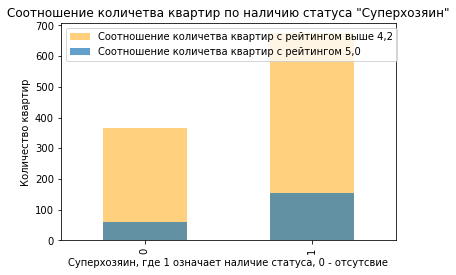

In [67]:
import matplotlib.pyplot as plt

a=df_subsubset.loc[df_subsubset['Рейтинг']>m]
b=df_subsubset.loc[df_subsubset['Рейтинг']==5]

r=a.groupby('Суперхозяин').size()
r.plot(kind='bar', color='orange',alpha=0.5, ylabel='%', label='Соотношение количетва квартир с рейтингом выше 4,2');
i=b.groupby('Суперхозяин').size()
i.plot(kind='bar',alpha=0.7, ylabel='%', label='Соотношение количетва квартир с рейтингом 5,0');

plt.ylabel('Количество квартир')
plt.xlabel('Суперхозяин, где 1 означает наличие статуса, 0 - отсутсвие')
plt.title('Соотношение количетва квартир по наличию статуса "Суперхозяин"')
plt.legend(loc='upper left')
plt.show()

Из графика видно, что обычных владельцев квартир с рейтингом, выше 4.2 и равным 5.0, больше, без статуса "Суперхозяина" достаточно много: в первом случае при рейтинге, выше 4.2, соотношение владельцев со статусом и без примерно 2:1, во втором случае при рейтинге, рамном 5.0, соотношение примерно 3:1. То есть в каждой рассматриваемой категории владельцев (по значению рейтинга) есть хозяева без статуса "Суперхозяина". 

#### Вывод:
Из произведенных расчетов и графика следует, что определенный процент владельцев квартир даже облдая выским рейтингом не всегода обладает статусом "Суперхозяин".

Гипотеза не подтвердилась: высокий рейтинг не связан с наличием статуса "Суперхозяин".

## Гипотеза

Существует корреляция между количеством удобств и ценой, количеством удобств и рейтингом.

Проверка гипотезы

Из датасета df_subset были выделены столбцы 'Количество удобств' и 'Цена', образовавшие таблицу x.

Из датасета df_subsubset, в котором имеется информация о квартирах с ненулевым рейтингом (если рейтинг равен 0, считается, что данных по рейтингу для этой квартиры нет), были выделены столбцы 'Количество удобств' и 'Рейтинг', образовавшие таблицу y.

Далее для столбцов каждой из созданных таблиц был посчитаны матрицы корреляции(k и k1).

In [68]:
x = df[['Количество удобств', 'Цена']] 
k=x.corr()
y=df_subsubset[['Количество удобств', 'Рейтинг']]
k1=y.corr()
print('Корреляция между ценой и количеством удобств: ')
print(k)
print('Корреляиця между рейтингом и количеством удобств:')
print(k1)

Корреляция между ценой и количеством удобств: 
                    Количество удобств      Цена
Количество удобств            1.000000  0.180233
Цена                          0.180233  1.000000
Корреляиця между рейтингом и количеством удобств:
                    Количество удобств   Рейтинг
Количество удобств            1.000000  0.126674
Рейтинг                       0.126674  1.000000


Как видно из матриц корреляций, коэффициенты очень малы, из чего следует, что между рейтингом и количеством удобств, ценой и количеством удобств нет взаимосвяязи.

##  Вывод

Гипотеза не подтвердилась: Корреляция между количеством удобств и ценой, количеством удобств и рейтингом отсутсвует.


## Гипотеза

Существует корреляция между оценкой чистоты и платой за уборку.

Проверка гипотезы

В некоторых случаях плата за убрку равна нулю, и таких случаев большинство - около 70 процентов, поэтоу посмотрим, есть ли корреляция, когда плата не равна нулю:

In [69]:
df[['Оценка чистоты', 'Плата за уборку']]
subsubset = df[df['Плата за уборку'] != 0]

In [170]:
subsubset[['Оценка чистоты', 'Плата за уборку']].corr()

Оценка чистоты  Плата за уборку
Оценка чистоты         1.000000        -0.048389
Плата за уборку       -0.048389         1.000000

### Вывод: корреляции нет. Гипотеза не подтверждена. 

## Гипотеза

Существует корреляция возможностью заехать самостоятельно и оценкой прибытия. 

Проверка гипотезы

In [172]:
df[['Самостоятельное прибытие', 'Оценка прибытия']].corr()

Самостоятельное прибытие  Оценка прибытия
Самостоятельное прибытие                   1.00000          0.24389
Оценка прибытия                            0.24389          1.00000

### Вывод: 
Корреляция не существенна, практически отсутствует. Поэтому на этот критерий можно не опираться. 